In [ ]:

"""
Author: Zhenggang Li & A.V. Ronquillo
Date: May 21, 2024

## Purpose: This notebook is a fast.ai ML model
## Note: Note: The author generated this text in part with GPT-4,
OpenAI’s large-scale language-generation model. Upon generating
draft code, the author reviewed, edited, and revised the code
to their own liking and takes ultimate responsibility for
the content of this code.

"""

This notebook is part of a project exploring the application of AI in wildlife documentation, specifically focusing on the classification of animal images. This introductory section outlines the project's aim and the role of this specific notebook within that context.

# Module: Import Python Packages and Mount Google Drive
In this module, we import essential packages for image processing and display them within Google CoLab Notebook. `fastai.vision.all` is a comprehensive library that includes all necessary methods for computer vision tasks, facilitating model building, training, and evaluation with just a few lines of code.

Additionally, mounting `google.colab import drive` gives the CoLab environment direct access to the dataset and files that will be used for analysis. Similarly, by importing the `Paths` class from `pathlib`, easier file manipulation can be utilized. `pathlib` is a module in the Python Standard Library that aids in handling filesystem paths with semantics that are appropriate for different operating systems.

In [ ]:
import os
from google.colab import drive
from fastai.vision.all import *
from pathlib import Path

##### Google Drive File Path
Implementing a function to mount Google Drive is needed in CoLab to enable files access. It uses `drive.mount('/content/drive', force_remount=True)` to force-mount the drive even if already mounted to ensure the session's directory structure is updated, followed by a print statement confirming the mount.

In [ ]:
def mount_google_drive():
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive is mounted. Proceed with file operations.")

# Module: Iterate Images for Error Handling

This section explains a function that safely gets image files from a given path. It allows the entire python script to be more robust because it prepares the image processing to be able to deal with unidentified or corrupted images.

The code takes an arguement of the `path` to the directory containing the images and initializes an empty list `"[]"` called `image_files`. This list will store the paths to the valid image files. Using the `get_image_files(path)` function in a `for` loop statement, this line of code iterates through the image files in the specified path.

For each image file, it attempts to open the image using the `PILImage.create()` function. If the image can be opened successfully, it means that the image is not corrupted and it is added to the `image_files` list. It will simply skip the image if an error occurs while opening the file and an indication of an error is printed. The function then runs through a `return` of the list of valid image files, ensuring that the image files used for training the model is not corrupted, which can lead to errors during training and can affect the performance of the model.

In [ ]:
def safe_get_image_files(path):
    image_files = []
    for img_path in get_image_files(path):
        try:
            # Attempt to open the image to verify it is not corrupted
            with PILImage.create(img_path) as img:
                image_files.append(img_path)
        except Exception as e:
            print(f"Skipping file {img_path} due to error: {e}")
    return image_files

# Module: Set Dataset Path & Gather Image Files

This module shows the function that processes image datasets for different dataset sizes. It states the three arguments, the `base_path` to the directory containing the image datasets , a list of `species` names, and a list of `dataset_sizes` that is iterated through. For each dataset size, it then initializes an empty list `"[]"` called `files`.

In [ ]:
def process_datasets(base_path, species, dataset_sizes):
    for size in dataset_sizes:
        files = []

By using another `for` loop statement, the `species` list is also iterated through. For each species, it constructs the `path` to the directory containing the images for that species and dataset size `{animal}_{size}` from each of their respective folders in the Google Drive. The code then calls the `safe_get_image_files()` function to get a list of image files from the directory and adds the list of image files to the `files` list. If this files list is empty, it means that no valid image files were found for the current dataset size, which would print a message and skips processing the dataset size.

In [ ]:
        # Gather files for all species for the given size
        for animal in species:
            path = Path(base_path) / f'{animal}_{size}'
            files += safe_get_image_files(path)

        if not files:
            print(f"No images found for dataset size {size}. Skipping...")
            continue

# Module: Initialize Data Loaders
This section of the notebook explains the function that initializes the data loaders for a given dataset. It is used to create a PyTorch DataLoader for images. If the files list is not empty, it initializes the data loaders using the `ImageDataLoaders.from_path_func()` function. The data loaders are used to load and pre-process the images, it then displays a batch of images from the data loaders through the use of the `dls.show_batch()` function. The `fnames` argument is the list of strings where each string is the `files` name of an image. The `label_func` argument then extracts the label for each image through the use of `lambda x`.

In [ ]:
        # Initialize Data Loaders
        dls = ImageDataLoaders.from_path_func(
            path=base_path,
            fnames=files,
            label_func=lambda x: x.parent.name.split('_')[0],

Transformations are applied to each batch of images to be resized to 224x224 through the `aug_transforms()` argument. The batch is displayed after the validation is set.

In [ ]:
            item_tfms=Resize(460),
            batch_tfms=aug_transforms(size=224),
            bs=32,
            num_workers=0,
            valid_pct=0.2  # ensure there is a validation set
        )

        dls.show_batch()

# Module: Initialize CNN Learner & Fine-Tune the Model
This module initializes a learner using a pre-trained convolutional neural network (CNN) architecture `resnet34`, in doing so, it sets up the model to measure `accuracy` as its performance metric. The model is then fine-tuned for `(4)` epochs, it adapts the pre-trained network's weights based on the specific data provided through `dls`, enhancing its ability to perform well on this particular dataset of animal images.

In [ ]:
        # Initialize CNN Learner and Fine-Tune the Model
        learn = cnn_learner(dls, resnet34, metrics=accuracy)
        learn.fine_tune(4)

Running the `learn.show_results()` generates a visualization that will aid in qualitatively assesing how the model is performing. For this image classification tasks, a grid of images from the validation set is displayed.
Each image in the displayed grid is annotated with the prediction made by the model and the true label. This dual annotation helps in quickly spotting where the model is performing well and where it is making errors.
This method is useful for getting a quick visual assessment of the effectiveness of the model.

In [ ]:
        # Display Model Results
        learn.show_results()

# Module: Plot a Confusion Matrix & Label the Datasets

The results of the model's performance is interpreted and visualized through a confusion matrix.

The `interp` variable is used to store the `ClassificationInterpretation` object. This object is a class from the "fastai" library designed to help interpret the outcomes of classification models. An interpretation of the results is then generated based on the trained model data, plotting a confusion matrix through `plt.show`. The number of correct and incorrect predictions made by the model compared with the actual classifications is displayed in the visual.

Additionally, the confusion matrix plot is represented with a labelled annotation of the dataset. `{size}` is replaced by the size of the dataset being used, and it is integrated dynamically into the title string. For example, the confusion matrix across the animal species in the dataset of 100 is labelled as "100 Dataset" at the top of the confusion matrix.

To further the clarification of the script's output, `60` dashes `'-'`, are printed to graphically separate the 100, 500, and 1000 Datasets.

In [ ]:
        # Interpret the Results and Plot a Confusion Matrix
        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix(title=f"{size} Dataset")
        plt.show()
        print(f'Processed dataset size {size}')
        print('-' * 60)

# Module: Process Datasets

This module ensures that necessary files from Google Drive are made accessible and eventually triggers the processing for each dataset size. It sets up the parameters for which data to process, including which `dataset_sizes` folder the images are stored in and what specific subdivisions or `species` of the data is to be used in the processing. This first run of the script is the 100 Dataset, the same steps are repated for each dataset in the notebook.

# 100 Dataset

In [ ]:
if __name__ == "__main__":
    mount_google_drive()
    base_path = '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets'
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 100  # Set to only process the 100 dataset
    process_dataset(base_path, species, dataset_size)


Output hidden; open in https://colab.research.google.com to view.

# 500 Dataset

Mounted at /content/drive
Google Drive is mounted. Proceed with file operations.


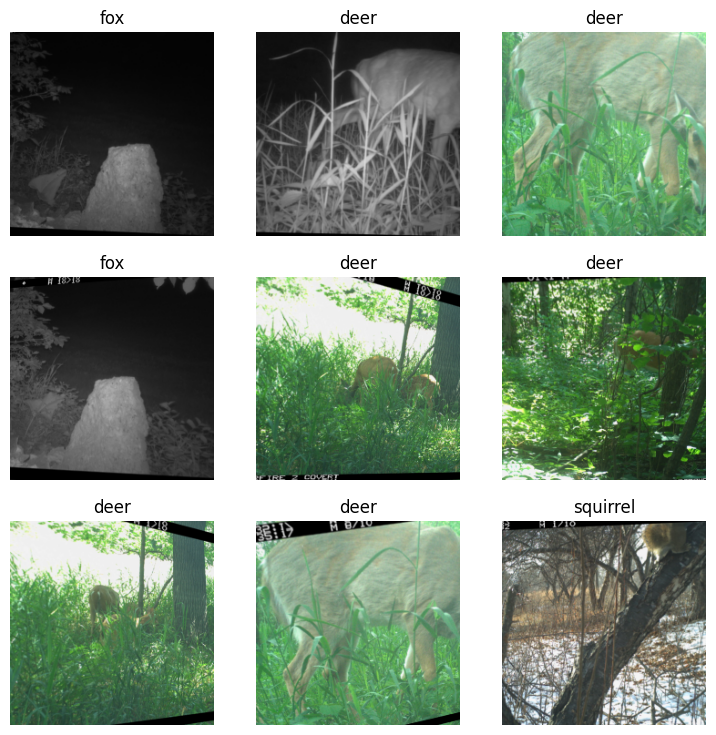

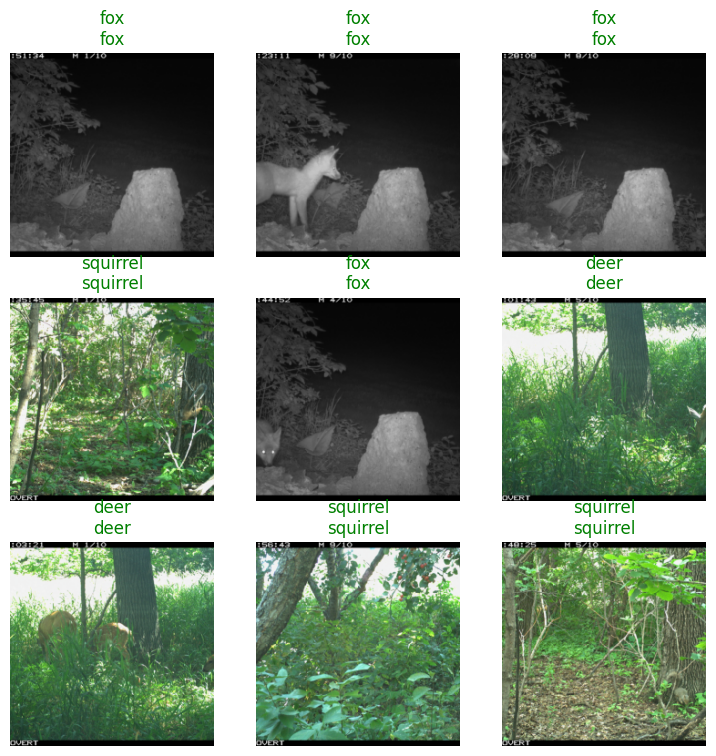

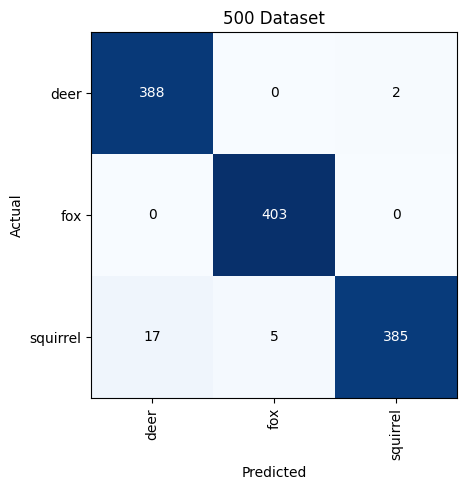

Processed dataset size 500
------------------------------------------------------------


In [ ]:
if __name__ == "__main__":
    mount_google_drive()
    base_path = '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets'
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 500  # Set to only process the 500 dataset
    process_dataset(base_path, species, dataset_size)

#1000 Dataset

Mounted at /content/drive
Google Drive is mounted. Proceed with file operations.
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_132.JPG due to error: cannot identify image file '/content/drive/.shortcut-targets-by-id/18rwXb8UvmanAn2HA5DlGRHoulqTTbUFs/shared-data/Notebook datafiles/av datasets/fox_1000/fox_132.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_121.JPG due to error: cannot identify image file '/content/drive/.shortcut-targets-by-id/18rwXb8UvmanAn2HA5DlGRHoulqTTbUFs/shared-data/Notebook datafiles/av datasets/fox_1000/fox_121.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_13.JPG due to error: cannot identify image file '/content/drive/.shortcut-targets-by-id/18rwXb8UvmanAn2HA5DlGRHoulqTTbUFs/shared-data/Notebook datafiles/av datasets/fox_1000/fox_13.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av dat

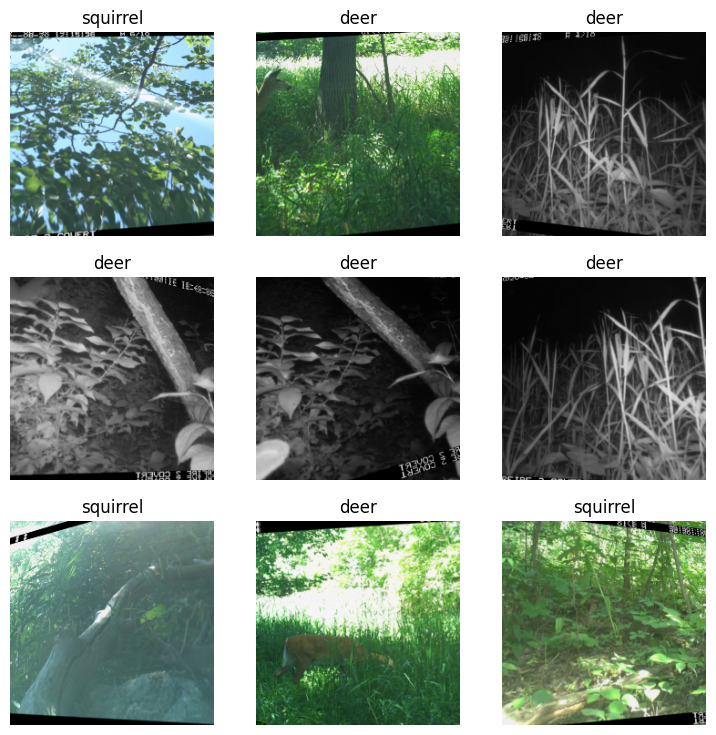

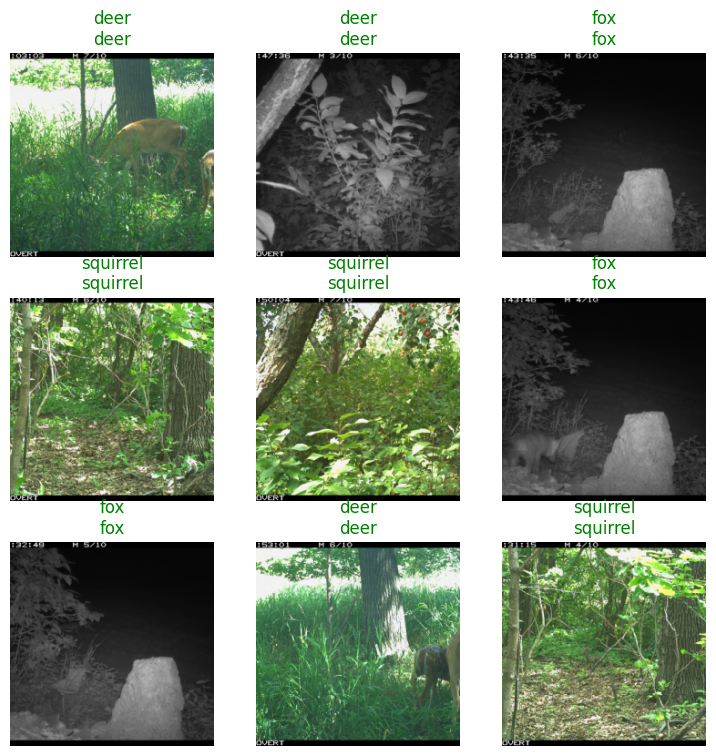

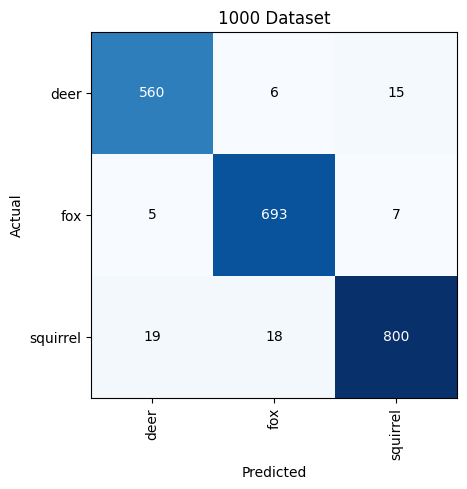

Processed dataset size 1000
------------------------------------------------------------


In [ ]:
if __name__ == "__main__":
    mount_google_drive()
    base_path = '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets'
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 1000  # Set to only process the 1000 dataset
    process_dataset(base_path, species, dataset_size)

# 5000 Dataset
Please note that because this script deals with such a large dataset, the free version of the CoLab environment is inadequate for the task. Therefore, the entire script was processed through the WSL environment on Linux and it was also tested in the cloud server of the Digital Research Alliance of Canada. Screenshots of the results are shown below.

In [ ]:
if __name__ == "__main__":
    mount_google_drive()
    base_path = '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets'
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 5000  # Set to only process the 5000 dataset
    process_dataset(base_path, species, dataset_size)

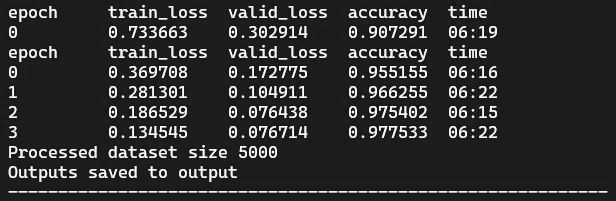

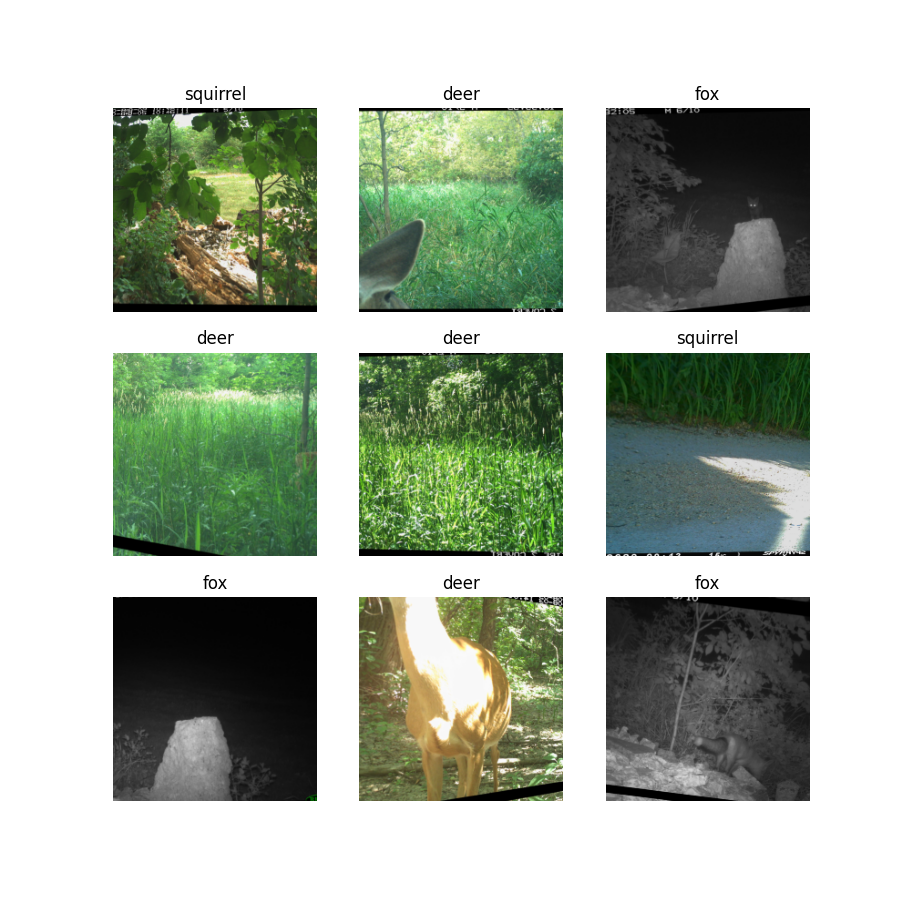

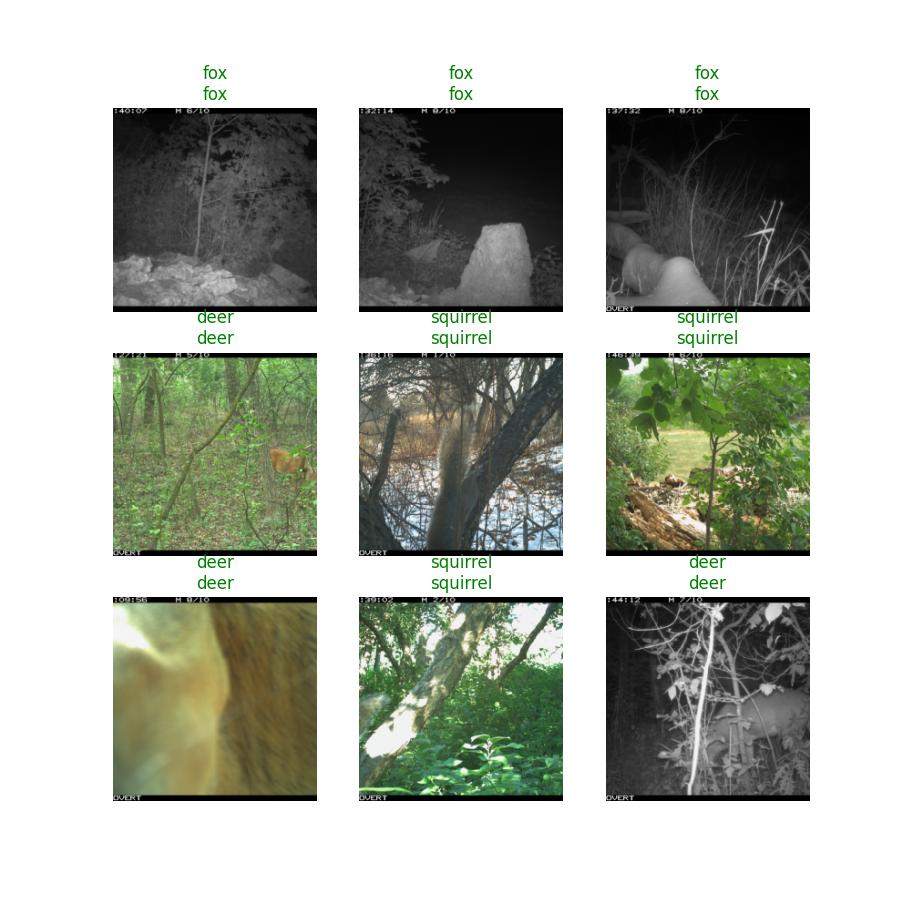

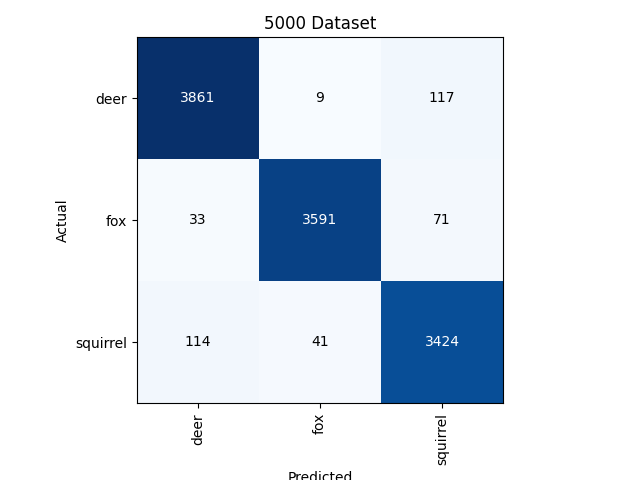

---------------------------
##### Classification Report

# Module: Importing Additional Necessary Python Packages


A similar script is used for generating a Classification Report for each dataset size. For the purposes of the notebook in CoLab and the consideration of the runtime, the classification report will only be visualized through the 100, 500, and 1000 dataset for further analysis of the model's animal classification accuracy.

The `matplotlib.pyplot` is assigned the alias of `plt`. This imported module is a library used for creating two-dimensional plots in Python. `sklearn.metrics` is used for visualization and model evaluation metrics. It essentially imports the `classification_report` function from the module. This element is another method of visualizing classification and localization accuracy in various quantitative metrics, allowing detailed model performance analysis. In doing so, it can provide insights that a confusion matrix may not necessarily offer. A classification report evaluates the performance of a classification model by calculating precision, recall, F1-score, and support for each class.

In [ ]:
import os
from google.colab import drive
from fastai.vision.all import *
from pathlib import Path

#Additional Packages
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

##### Google Drive File Path

In [ ]:
def mount_google_drive():
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive is mounted. Proceed with file operations.")

# Module: Repeating Error Handling Functions

The same snippet of code that focuses on error handling in image files from the original script will be used.

In [ ]:
def safe_get_image_files(path):
    image_files = []
    for img_path in get_image_files(path):
        try:
            # Attempt to open the image to verify it is not corrupted
            with PILImage.create(img_path) as img:
                image_files.append(img_path)
        except Exception as e:
            print(f"Skipping file {img_path} due to error: {e}")
    return image_files

# Module: Data Processing & Fine-Tuning the Model

In this module, the same lines of code of gathering images based on `species` and `size` is also repeated.

The `cnn_learner` is still using the `resnet34` architecture as well as fastai, and it ensures that the model focuses on using `accuracy` as the model's metric for image classification and localization accuracy. The model is then fine-tuned for `4` epochs.

In [ ]:
def process_dataset(base_path, species, size):
    files = []
    # Gather files for all species for the given size
    for animal in species:
        path = Path(base_path) / f'{animal}_{size}'
        files += safe_get_image_files(path)

    if not files:
        print(f"No images found for dataset size {size}. Skipping...")
        return

    # Initialize Data Loaders
    dls = ImageDataLoaders.from_path_func(
        path=base_path,
        fnames=files,
        label_func=lambda x: x.parent.name.split('_')[0],
        item_tfms=Resize(460),
        batch_tfms=aug_transforms(size=224),
        bs=32,
        num_workers=0,
        valid_pct=0.8  # ensure there is a validation set
    )

    # Initialize CNN Learner and Fine-Tune the Model
    learn = cnn_learner(dls, resnet34, metrics=accuracy)
    learn.fine_tune(4)

# Module: Retrieving Predictions & True Labels
After the training, the model's predictions and true labels are retrieved. By using a container tuple, the `get_preds` method gathers the predicted probabilities and the true labels. The raw predictions outputs are converted to probabilities using the `preds_softmax` function that sum to 1 for each sample.

The `max` function is applied along the first dimension where (axis=1), which corresponds to the different classes. The `predicted_probs` variable contains the maximum probabilities, and the `actual_classes` variable contains the predicted class labels.

In [ ]:
    preds, y_true = learn.get_preds()
    preds_softmax = preds.softmax(dim=1)
    predicted_probs, actual_classes = preds_softmax.max(dim=1)

# Module: Converting the Report into a Pandas DataFrame

By using the `argmax` function, the `y_pred` calculates the predicted class labels by taking the maximum value along the first dimension `(dim-1)` of the `preds_softmax` tensor. This establishes that the `preds_softmax` contains the predicted probabilities for each class.

The `report` function generates the `classification_report` from the `sklearn.metrics` module that was previously imported. It takes the true labels `y_true` and the predicted class labels `y_pred` as input, and sets `output_dict=True` to return the report as a dictionary. In doing so, it can allow access to the individual metrics for each class, including the overall metrics in a more structured manner.

Transposing the `DataFrame` swaps the rows and columns so that class labels become the index and the metrics (precision, recall, f1-score, etc.) become the columns.

In [ ]:
    # Assuming y_true and preds_softmax are your true labels and output probabilities.
    y_pred = preds_softmax.argmax(dim=1)
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()

# Module: Keys Dictionary & Generating the Classification Visual

The dictionary for the report contains these keys:

  `accuracy`: Overall classification accuracy of the model. The percentage of correctly predicted instances out of all instances in the dataset.

  `macro avg`: The macro-averaged precision, recall, f1-score, and support across all classes. This calculates the metric for each class and then takes the average across all classes. This gives equal weight to each class, regardless of the number of instances in each class.

  `weighted avg`: Weighted average of the precision, recall, f1-score, and support across all classes. Weighted averaging calculates each class metric by the number of instances in that class, giving more weight to larger classes.





  Class-specific metrics: For each class, the dictionary contains the following metrics:

  `precision`: The percentage of predicted positive instances that are actually positive. It is calculated as the number of true positives divided by the total number of predicted positives.

  `recall`: The percentage of actual positive instances that are predicted to be positive. It is calculated as the number of true positives divided by the total number of actual positives.

  `f1-score`: The harmonic mean of precision and recall. It is calculated as 2 * (precision * recall) / (precision + recall).

  `support`: Number of true instances for the class


  These metrics can provide a sharper control of how you want to evaluate the model's performance on each class individually. Therefore it can be useful for identifying classes that the model is struggling with or for comparing the model's performance.

In [ ]:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x=df.index, y='precision', label='Precision', color='b')
    sns.barplot(data=df, x=df.index, y='recall', label='Recall', color='r', alpha=0.6)
    sns.barplot(data=df, x=df.index, y='f1-score', label='F1-Score', color='g', alpha=0.3)
    plt.xticks(rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title(f'Classification Report for {size} Dataset')
    plt.legend()
    plt.show()

`figsize` ensures that the specified size of the visual is 10 inches wide and 6 inches high. By using the Seaborn library, the `sns.barplot` creates a bar graph visual. The `label` argument specifies the label for the plot, and the `color` argument specifies the color of the bars. The `alpha` arguement controls the transparency of the `recall` bar as well as the `f1-score`. These parameters can be controlled to your liking in terms of what you want to communicate through the classification report.

# Module: Process Datasets to create the Classification Report

Similar to initializing the Confusion Matrix generation, this module uses the same snippet of code to process each dataset size for the Classification Report. In doing so, it ensures that necessary files and dataset sizes from Google Drive are made accessible for processing. This first run of the script is the  Classification Report for the 100 Dataset, the same steps are repated for each dataset in the notebook.

# 100 Dataset

Mounted at /content/drive
Google Drive is mounted. Proceed with file operations.


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.3MB/s]


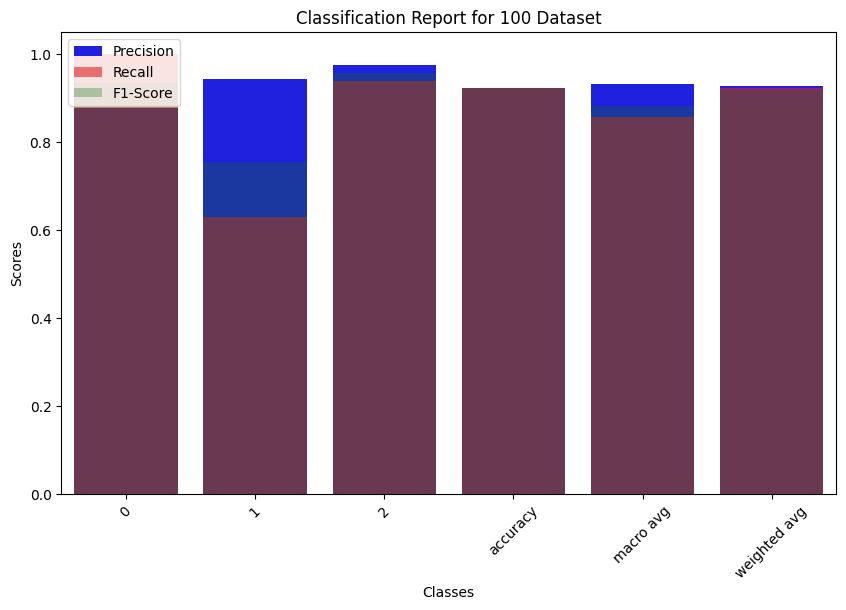

In [ ]:
if __name__ == "__main__":
    mount_google_drive()
    base_path = '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets'
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 100
    process_dataset(base_path, species, dataset_size)

# 500 Dataset

Mounted at /content/drive
Google Drive is mounted. Proceed with file operations.


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


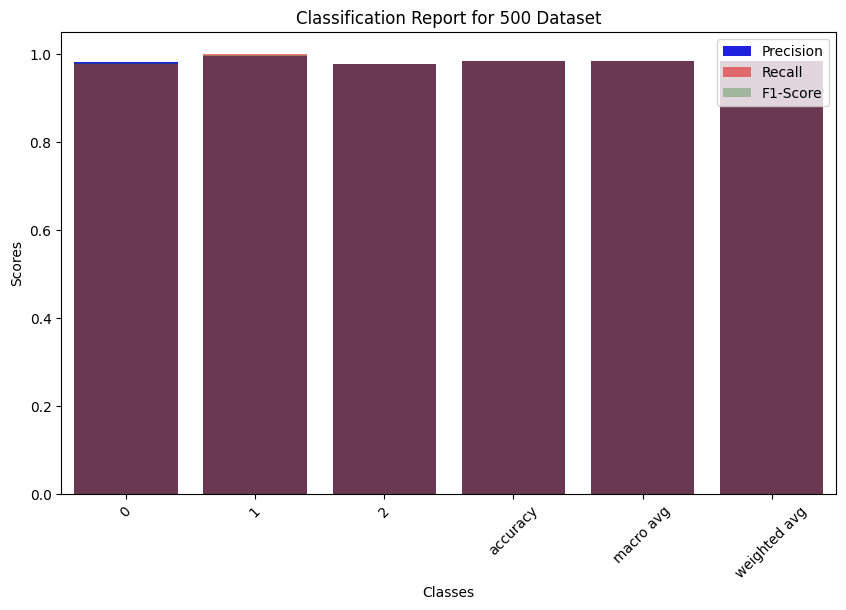

In [ ]:
if __name__ == "__main__":
    mount_google_drive()
    base_path = '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets'
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 500
    process_dataset(base_path, species, dataset_size)

Mounted at /content/drive
Google Drive is mounted. Proceed with file operations.
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_132.JPG due to error: cannot identify image file '/content/drive/.shortcut-targets-by-id/18rwXb8UvmanAn2HA5DlGRHoulqTTbUFs/shared-data/Notebook datafiles/av datasets/fox_1000/fox_132.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_121.JPG due to error: cannot identify image file '/content/drive/.shortcut-targets-by-id/18rwXb8UvmanAn2HA5DlGRHoulqTTbUFs/shared-data/Notebook datafiles/av datasets/fox_1000/fox_121.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_13.JPG due to error: cannot identify image file '/content/drive/.shortcut-targets-by-id/18rwXb8UvmanAn2HA5DlGRHoulqTTbUFs/shared-data/Notebook datafiles/av datasets/fox_1000/fox_13.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av dat

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


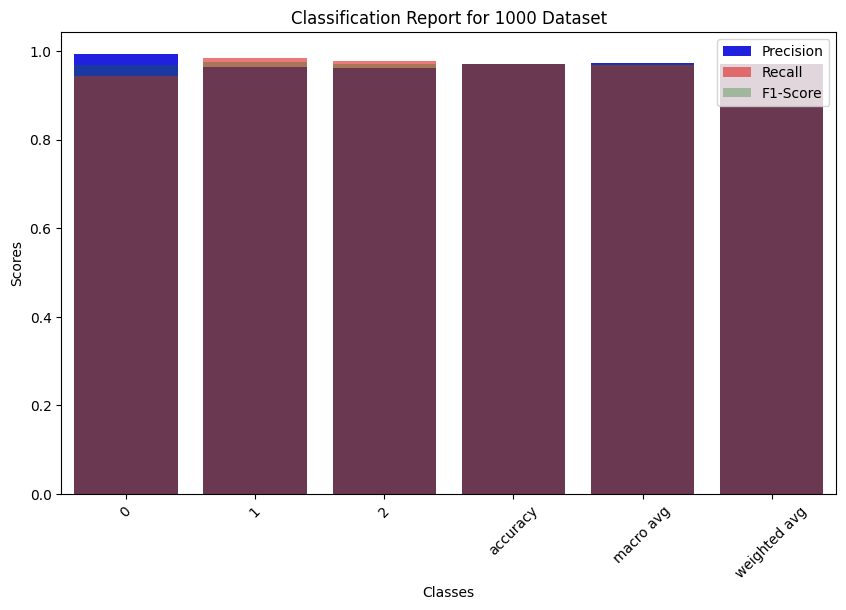

In [ ]:
if __name__ == "__main__":
    mount_google_drive()
    base_path = '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets'
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 1000
    process_dataset(base_path, species, dataset_size)